# Desarrollo de un sistema de diagnóstico de enfermedades en hojas de tomate mediante PlantCV y modelos de aprendizaje profundo

La detección temprana de enfermedades en cultivos es vital para la agricultura sostenible. Utilizando PlantCV (https://plantcv.readthedocs.io/), una biblioteca enfocada en la visión por computadora para plantas, junto con TensorFlow o PyTorch, el alumno se encargará de crear modelos de clasificación multiclase robustos. Estos modelos tendrán como objetivo identificar 10 distintas enfermedades y una clase de salud en hojas de tomate. Para el entrenamiento y evaluación, se usará el Tomato Leaves Dataset de Kaggle (https://www.kaggle.com/datasets/ashishmotwani/tomato), que contiene más de 20,000 imágenes recogidas en entornos de laboratorio e in situ. Dada la naturaleza práctica de la aplicación, se buscará desarrollar un modelo lo suficientemente eficiente como para poder ser implementado en aplicaciones móviles, permitiendo diagnósticos ágiles y efectivos en el campo.

## Carga de la data

Debido a que solo existe data para train y validacion, se procede a separar un porcentaje para hacer un test final.

In [2]:
from src.utils.data_distribution import create_test_set

create_test_set("./data/train", "./data/test", percentage=10)

Se movió el 10% de imágenes de train a test correctamente.


Ya que existen nombres de archivos muy extensos es recomendable renombrarlos a una cantidad de caracteres mas manejables

In [1]:
from src.utils.rename_files import rename_images_in_directory
base_directory = "data"
rename_images_in_directory(base_directory)

Renombrando imágenes en: data\train\Bacterial_spot
Renombrando imágenes en: data\train\Early_blight
Renombrando imágenes en: data\train\healthy
Renombrando imágenes en: data\train\Late_blight
Renombrando imágenes en: data\train\Leaf_Mold
Renombrando imágenes en: data\train\powdery_mildew
Renombrando imágenes en: data\train\Septoria_leaf_spot
Renombrando imágenes en: data\train\Spider_mites Two-spotted_spider_mite
Renombrando imágenes en: data\train\Target_Spot
Renombrando imágenes en: data\train\Tomato_mosaic_virus
Renombrando imágenes en: data\train\Tomato_Yellow_Leaf_Curl_Virus
Renombrando imágenes en: data\valid\Bacterial_spot
Renombrando imágenes en: data\valid\Early_blight
Renombrando imágenes en: data\valid\healthy
Renombrando imágenes en: data\valid\Late_blight
Renombrando imágenes en: data\valid\Leaf_Mold
Renombrando imágenes en: data\valid\powdery_mildew
Renombrando imágenes en: data\valid\Septoria_leaf_spot
Renombrando imágenes en: data\valid\Spider_mites Two-spotted_spider_m

In [1]:
# codigo para cargar la data y prepararla
from src.utils.data_loader import get_data_loaders

data_dir = "data"
train_loader, valid_loader, test_loader, class_names = get_data_loaders(data_dir)

print(f"Clases detectadas: {class_names}")


Clases detectadas: ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']


In [ ]:
#falta el procesamiento con plantcv

## Exploracion de los datos

In [3]:
from src.utils.data_distribution import dataset_summary
dataset_summary(train_loader.dataset, valid_loader.dataset, test_loader.dataset)


Resumen de imágenes por clase:
----------------------------------------
📌 Conjunto de Entrenamiento: 23266 imágenes en total
  Bacterial_spot: 2570 imágenes
  Early_blight: 2187 imágenes
  Late_blight: 2807 imágenes
  Leaf_Mold: 2488 imágenes
  Septoria_leaf_spot: 2606 imágenes
  Spider_mites Two-spotted_spider_mite: 1568 imágenes
  Target_Spot: 1639 imágenes
  Tomato_Yellow_Leaf_Curl_Virus: 1822 imágenes
  Tomato_mosaic_virus: 1948 imágenes
  healthy: 2730 imágenes
  powdery_mildew: 901 imágenes

📌 Conjunto de Validación: 2585 imágenes en total
  Bacterial_spot: 256 imágenes
  Early_blight: 268 imágenes
  Late_blight: 306 imágenes
  Leaf_Mold: 266 imágenes
  Septoria_leaf_spot: 276 imágenes
  Spider_mites Two-spotted_spider_mite: 179 imágenes
  Target_Spot: 188 imágenes
  Tomato_Yellow_Leaf_Curl_Virus: 217 imágenes
  Tomato_mosaic_virus: 205 imágenes
  healthy: 321 imágenes
  powdery_mildew: 103 imágenes

📌 Conjunto de Pruebas: 6683 imágenes en total
  Bacterial_spot: 732 imágenes
  

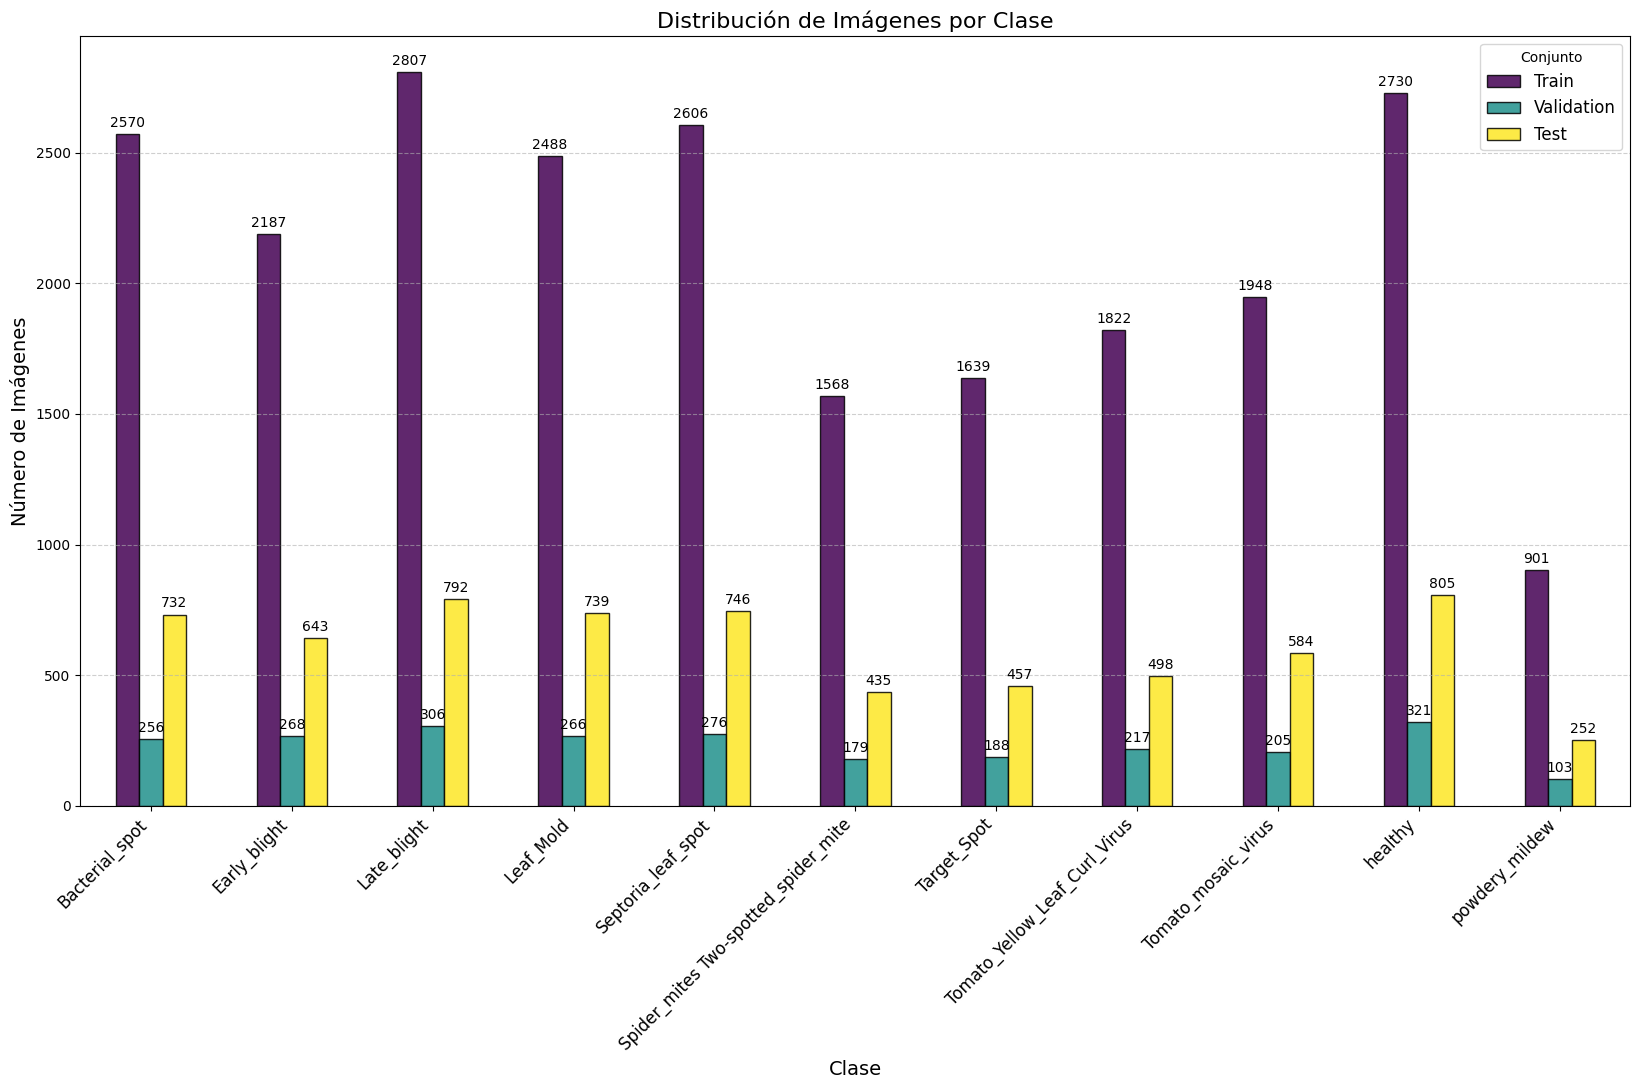

In [4]:
# codigo para explorar caracteristicas escenciales, con plantCV y demas librerias
# para ver tamanos, balance de train y validacion, separar un poco para el test
from src.utils.data_distribution import plot_class_distribution

plot_class_distribution(train_loader, valid_loader, test_loader, class_names)

## Modelos de clasificacion multiclases

In [1]:
!nvidia-smi

Thu Feb 13 22:11:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   49C    P8              4W /   33W |     586MiB /   8188MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Se crean los modelos y se los entrenan
from src.models.model import TomatoDiseaseClassifier

# Número de clases detectadas en el dataset
num_classes = len(class_names)

# Inicializar el modelo
model = TomatoDiseaseClassifier(num_classes)
print(model)


In [ ]:
#pip install torch==2.1.0+cu121 torchvision==0.16.0+cu121 --index-url https://download.pytorch.org/whl/cu121 --timeout 1000 --retries 10
import torch

if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"{device_count} GPU(s) available:")
    for i in range(device_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No CUDA compatible GPU detected.")


In [ ]:
from src.models.train import train_model

# Definir hiperparámetros
num_epochs = 20
learning_rate = 0.001

# Entrenar el modelo
trained_model = train_model(model, train_loader, valid_loader, num_epochs, learning_rate)

## Comparacion de los mejores modelos obtenidos

In [ ]:
# Se compara los modelos obtenidos y se decide por el mejor

## Predicciones con el mejor modelo para este caso

In [ ]:
#Se crea una clase para hacer la prediccion en base a una imagen nueva